# Introdução

Neste arquivo estão o tratamento dos dados e os códigos das análises feitas. As análises foram feitas efetivamente num arquivo separado e disponibilizado a parte, chamado `analise_restaurantes.pdf`, criado com $\LaTeX$.

# Tratamento dos dados

## Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

print('Importação finalizada')

Importação finalizada


## Leitura dos dados

### Observações importantes sobre a leitura dos dados

Duas observações importantes no tratamento dos dados: primeiramente, foi necessário salvar a tabela original de Excel em outro arquivo, nomeado `dados_gks_2.xlsx`, para poder fazer sua leitura pelo pacote `pandas`. Segundo, acredito que os dados eram originalmente do PowerBI, que possui um limite maior de gerenciamento de dados. 

O Excel possui uma limitação de 1.048.576 linhas por planilha, que gerou erros na abertura do arquivo e ocasionou a necessidade de salvar em um arquivo diferente. É melhor exportar os dados em formato `.csv`, que é mais leve que o Excel e não possui tal limitação.

In [2]:
# Leitura do arquivo excel
df = pd.read_excel('dados_gks_2.xlsx', skiprows=2, sheet_name='Tabela')
df.head()

,Nível,Cód.,"Grande Região, Unidade da Federação e Município",Ano,Classificação Nacional de Atividades Econômicas (CNAE 2.0),Unnamed: 5
0,GR,1.0,Norte,2017.0,49 Transporte terrestre,5173
1,NaN,NaN,NaN,NaN,49.1 Transporte ferroviário e metroferroviário,7
2,NaN,NaN,NaN,NaN,49.11-6 Transporte ferroviário de carga,7
3,NaN,NaN,NaN,NaN,49.12-4 Transporte metroferroviário de passage...,-
4,NaN,NaN,NaN,NaN,49.21-3 Transporte rodoviário coletivo de pass...,395


Pela inicialização da tabela vemos alguns pontos que precisam ser tratados:
- Existem muitos dados faltantes (representados pela sigla `NaN`, que significa `Not a Number`) com diferentes naturezas: os dados faltantes de nível, código, região e ano referem-se a uma extensão do primeiro valor não-nulo. Por exemplo, nas cinco linhas mostradas basta repetir as informações da primeira (pois todas as linhas correspondem ao mesmo nível, código, região, e ano). Entretanto, os dados faltantes na última coluna referem-se às quantidades de unidades locais na determinada região, ou seja, a falta de dado será tratada como falta de pessoas naquela atividade. Portanto, esses dados faltantes serão substituídos por zero;
- A classificação do CNAE será mais legível se dividirmos em duas novas colunas: uma coluna para o código e uma coluna para a descrição da atividade;
- A última coluna precisa ser renomeada, pois a leitura automática da tabela não interpretou o nome ou o nome não foi fornecido nos dados.

In [3]:
# Renomeando a coluna
df.rename(columns={'Unnamed: 5' : 'Unidades locais'}, inplace=True)
df.head()

,Nível,Cód.,"Grande Região, Unidade da Federação e Município",Ano,Classificação Nacional de Atividades Econômicas (CNAE 2.0),Unidades locais
0,GR,1.0,Norte,2017.0,49 Transporte terrestre,5173
1,NaN,NaN,NaN,NaN,49.1 Transporte ferroviário e metroferroviário,7
2,NaN,NaN,NaN,NaN,49.11-6 Transporte ferroviário de carga,7
3,NaN,NaN,NaN,NaN,49.12-4 Transporte metroferroviário de passage...,-
4,NaN,NaN,NaN,NaN,49.21-3 Transporte rodoviário coletivo de pass...,395


Fazemos agora uma contagem de quantos valores não-nulos existem, assim como os formatos de dados que foram armazenados os dados da tabela.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048573 entries, 0 to 1048572
Data columns (total 6 columns):
 #   Column                                                      Non-Null Count    Dtype  
---  ------                                                      --------------    -----  
 0   Nível                                                       3813 non-null     object 
 1   Cód.                                                        3813 non-null     float64
 2   Grande Região, Unidade da Federação e Município             3813 non-null     object 
 3   Ano                                                         19065 non-null    float64
 4   Classificação Nacional de Atividades Econômicas (CNAE 2.0)  1048573 non-null  object 
 5   Unidades locais                                             1048573 non-null  object 
dtypes: float64(2), object(4)
memory usage: 48.0+ MB


Observamos que existem 3813 valores não-nulos para as colunas `Nível`, `Cód.` e `Grande Região, Unidade da Federação e Município`. Isso corrobora a ideia de que essas informações aparecem uma vez e repetem-se para as linhas abaixo, conforme mostrado na primeira linha da tabela.

O comando também mostrou que:
- As colunas `Nível`, `Grande Região, Unidade da Federação e Município`, `Classificação Nacional de Atividades Econômicas (CNAE 2.0)`e `Unidades locais` possuem formato de dado `object`, que é o formato adotado pelo pacote `pandas` quando não é capaz de inferir o tipo correto de dado; e
- As colunas `Cód.` e `Ano` estão com formato `float64`, para dados numéricos decimais.

Como próximo passo, mostramos quantos dados nulos aparecem na tabela.

In [5]:
df.isna().sum()

Nível                                                         1044760
Cód.                                                          1044760
Grande Região, Unidade da Federação e Município               1044760
Ano                                                           1029508
Classificação Nacional de Atividades Econômicas (CNAE 2.0)          0
Unidades locais                                                     0
dtype: int64

Antes de preencher os dados faltantes faremos uma alteração, transformando a coluna `Classificação Nacional de Atividades Econômicas (CNAE 2.0)` em duas colunas, uma coluna contendo o código CNAE e outra contendo o nome da atividade, em seguida deletando a coluna.

In [6]:
df[['Código CNAE', 'Atividade']] = df['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str.extract(r'^([\d.-]+)\s(.*)$')
df = df.drop(columns=['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'])
df.head()

,Nível,Cód.,"Grande Região, Unidade da Federação e Município",Ano,Unidades locais,Código CNAE,Atividade
0,GR,1.0,Norte,2017.0,5173,49,Transporte terrestre
1,NaN,NaN,NaN,NaN,7,49.1,Transporte ferroviário e metroferroviário
2,NaN,NaN,NaN,NaN,7,49.11-6,Transporte ferroviário de carga
3,NaN,NaN,NaN,NaN,-,49.12-4,Transporte metroferroviário de passageiros
4,NaN,NaN,NaN,NaN,395,49.21-3,"Transporte rodoviário coletivo de passageiros,..."


Reordenamos as colunas para voltar ao formato com o código e atividade antes da quantidade de unidades locais.

In [7]:
df = df.reindex(columns=['Nível', 'Cód.', 'Grande Região, Unidade da Federação e Município', 'Ano', 'Código CNAE', 'Atividade', 'Unidades locais'])
df.head()

,Nível,Cód.,"Grande Região, Unidade da Federação e Município",Ano,Código CNAE,Atividade,Unidades locais
0,GR,1.0,Norte,2017.0,49,Transporte terrestre,5173
1,NaN,NaN,NaN,NaN,49.1,Transporte ferroviário e metroferroviário,7
2,NaN,NaN,NaN,NaN,49.11-6,Transporte ferroviário de carga,7
3,NaN,NaN,NaN,NaN,49.12-4,Transporte metroferroviário de passageiros,-
4,NaN,NaN,NaN,NaN,49.21-3,"Transporte rodoviário coletivo de passageiros,...",395


Agora preenchemos os dados faltantes das colunas `Nível`, `Cód.`, `Grande Região, Unidade da Federação e Município`, e `Ano` com o método `forward-fill`, que copia a primeira célula não-vazia até encontrar outra célula não-vazia, repetindo o processo.

In [8]:
df[['Nível', 'Cód.', 'Grande Região, Unidade da Federação e Município', 'Ano']] = df[['Nível', 'Cód.', 'Grande Região, Unidade da Federação e Município', 'Ano']].fillna(method='ffill')
df.head()

,Nível,Cód.,"Grande Região, Unidade da Federação e Município",Ano,Código CNAE,Atividade,Unidades locais
0,GR,1.0,Norte,2017.0,49,Transporte terrestre,5173
1,GR,1.0,Norte,2017.0,49.1,Transporte ferroviário e metroferroviário,7
2,GR,1.0,Norte,2017.0,49.11-6,Transporte ferroviário de carga,7
3,GR,1.0,Norte,2017.0,49.12-4,Transporte metroferroviário de passageiros,-
4,GR,1.0,Norte,2017.0,49.21-3,"Transporte rodoviário coletivo de passageiros,...",395


Isto garante que, quando reorganizarmos a tabela em diferentes modos poderemos indexar por nível, código, região ou outra variável.

Agora substituímos os dados faltantes na coluna `Unidades locais`, colocando `0` no lugar de `-`.

In [9]:
df[['Unidades locais']] = df[['Unidades locais']].replace(to_replace='-', value='0')
df.head()

,Nível,Cód.,"Grande Região, Unidade da Federação e Município",Ano,Código CNAE,Atividade,Unidades locais
0,GR,1.0,Norte,2017.0,49,Transporte terrestre,5173
1,GR,1.0,Norte,2017.0,49.1,Transporte ferroviário e metroferroviário,7
2,GR,1.0,Norte,2017.0,49.11-6,Transporte ferroviário de carga,7
3,GR,1.0,Norte,2017.0,49.12-4,Transporte metroferroviário de passageiros,0
4,GR,1.0,Norte,2017.0,49.21-3,"Transporte rodoviário coletivo de passageiros,...",395


Verificando que todos os dados faltantes foram preenchidos:

In [10]:
df.isna().sum()

Nível                                              0
Cód.                                               0
Grande Região, Unidade da Federação e Município    0
Ano                                                0
Código CNAE                                        0
Atividade                                          0
Unidades locais                                    0
dtype: int64

Mudamos os tipos de dados das colunas para finalizar o tratamento de dados:

In [11]:
df = df.astype({'Nível' : "category", 'Cód.' : int, 'Grande Região, Unidade da Federação e Município' : "category", 'Ano' : int, 'Código CNAE' : "category", 'Atividade' : "category", 'Unidades locais' : int})
df.dtypes

Nível                                              category
Cód.                                                  int32
Grande Região, Unidade da Federação e Município    category
Ano                                                   int32
Código CNAE                                        category
Atividade                                          category
Unidades locais                                       int32
dtype: object

As colunas `Cód.`, `Ano` e `Unidades locais` foram alteradas para inteiro e as colunas `Nível`, `Grande Região, Unidade da Federação e Município`, `Código CNAE` e `Atividade` foram alteradas para `category`, que é um tipo especial de dado em pandas otimizado para categorias, ocupando menos memória e facilitando o uso.

Vamos criar também um dicionário fazendo uma correspondência entre as atividades e seus respectivos códigos CNAE, caso necessário.

In [12]:
# Selecionando os códigos distintos da CNAE
codigos_cnae = df['Código CNAE'].unique()

# Selecionando as atividades distintas da CNAE
atividades_cnae = df['Atividade'].unique()

# Criando o dicionário de correspondências
dicio_cnae = {atividade : codigo for codigo, atividade in zip(codigos_cnae, atividades_cnae)}

## Criação das tabelas regionais

Agora criaremos três tabelas separadamente:
- Uma tabela apenas para as grandes regiões, escolhendo regiões com códigos atendendo `Cód. > 0` e `Cód. < 10`, que correspondem apenas às macrorregiões (Centro-Oeste, Nordeste, Norte, Sudeste, Sul);
- Uma tabela apenas para as unidades da federação, escolhendo regiões com códigos `Cód. > 10` e `Cód. < 100`;
- Uma tabela apenas para os municípios, escolhendo regiões com códigos `Cód. > 100`.

In [13]:
# Construindo a tabela das grandes regiões
grand_reg = df.copy()
grand_reg = grand_reg[(grand_reg['Cód.'] > 0) & (grand_reg['Cód.'] < 10)]

# Renomeando as colunas
grand_reg = grand_reg.rename(columns={'Grande Região, Unidade da Federação e Município' : 'Região'})

# Retirando colunas desnecessárias
grand_reg = grand_reg.drop(columns=['Nível', 'Cód.', 'Código CNAE'])

grand_reg.head()

,Região,Ano,Atividade,Unidades locais
0,Norte,2017,Transporte terrestre,5173
1,Norte,2017,Transporte ferroviário e metroferroviário,7
2,Norte,2017,Transporte ferroviário de carga,7
3,Norte,2017,Transporte metroferroviário de passageiros,0
4,Norte,2017,"Transporte rodoviário coletivo de passageiros,...",395


Aqui realizamos os seguintes procedimentos:
1. Selecionamos as linhas na tabela original com códigos no intervalo especificado;
2. Uma vez com as linhas selecionadas, renomeamos a coluna da região para `Grande Região`, uma vez que não possui mais unidades da federação e municípios;
3. Retiramos as colunas `Nível`, `Cód.` e `Código CNAE` nessa tabela, pois é mais simples guiar-se pela atividade, além de termos o dicionário para descobrir os códigos, se necessário.

Realizaremos os mesmos procedimentos nas tabelas de unidades da federação e de municípios.

In [14]:
# Construindo a tabela das unidades da federação
unid_feds = df.copy()
unid_feds = unid_feds[(unid_feds['Cód.'] > 10) & (unid_feds['Cód.'] < 100)]

# Renomeando as colunas
unid_feds = unid_feds.rename(columns={'Grande Região, Unidade da Federação e Município' : 'Região'})

# Reiniciando o índice
unid_feds = unid_feds.reset_index(drop=True)

# Retirando colunas desnecessárias
unid_feds = unid_feds.drop(columns=['Nível', 'Cód.', 'Código CNAE'])
unid_feds.head()

,Região,Ano,Atividade,Unidades locais
0,Rondônia,2017,Transporte terrestre,1415
1,Rondônia,2017,Transporte ferroviário e metroferroviário,0
2,Rondônia,2017,Transporte ferroviário de carga,0
3,Rondônia,2017,Transporte metroferroviário de passageiros,0
4,Rondônia,2017,"Transporte rodoviário coletivo de passageiros,...",44


In [15]:
# Construindo a tabela dos municípios
municipios = df.copy()
municipios = municipios[municipios['Cód.'] > 100]

# Renomeando as colunas
municipios = municipios.rename(columns={'Grande Região, Unidade da Federação e Município' : 'Região'})

# Reiniciando o índice
municipios = municipios.reset_index(drop=True)

# Retirando colunas desnecessárias
municipios = municipios.drop(columns=['Nível', 'Cód.', 'Código CNAE'])
municipios.head()

,Região,Ano,Atividade,Unidades locais
0,Alta Floresta D'Oeste (RO),2017,Transporte terrestre,28
1,Alta Floresta D'Oeste (RO),2017,Transporte ferroviário e metroferroviário,0
2,Alta Floresta D'Oeste (RO),2017,Transporte ferroviário de carga,0
3,Alta Floresta D'Oeste (RO),2017,Transporte metroferroviário de passageiros,0
4,Alta Floresta D'Oeste (RO),2017,"Transporte rodoviário coletivo de passageiros,...",3


# Análises

## Regressão Linear

Aqui agrupamos as primeiras funções auxiliares para construção dos gráficos e determinação das tabelas necessárias.

### Cálculos auxiliares

Esta função representa a seleção por subconjunto de atividade e/ou região de uma tabela.

In [16]:
def subconj_df(df=None, ativ=None, reg=None, col1='Região', col2='Atividade'):
    """Função para selecionar por subconjunto de região e/ou atividade."""
    por_ativ = df[df[col2] == ativ]

    # Seleção por região e atividade
    if reg is not None:
        por_ativ_e_reg = por_ativ[por_ativ[col1] == reg]
        return por_ativ_e_reg

    # Se região não for selecionada, apenas por atividade
    return por_ativ

Esta função realiza os cálculos de determinação dos coeficientes do modelo de regressão linear, ajustando o modelo aos dados e apresentando o valor de $R^2$.

In [17]:
def calculo_reg_lin(df=None, x='Ano', y='Unidades locais'):
    """Cálculo dos coeficientes da regressão linear juntamente com R2."""
    # Instanciação do modelo
    lin_reg = LinearRegression()

    # Ajuste do modelo aos dados
    lin_reg.fit(df[[x]], df[y])

    # Determinação dos coeficientes e de R2
    coef_ang = lin_reg.coef_
    coef_lin = lin_reg.intercept_
    r_quad = lin_reg.score(df[[x]], df[y])

    return coef_ang, coef_lin, r_quad

Esta função cria valores de interpolação para criação da reta de regressão linear. É uma função intermediária para uso no desenho do gráfico.

In [18]:
def val_interp(df=None, a=None, b=None, col='Ano'):
    """Função para criação de pontos da regressão linear"""
    # Determinação dos pontos x entre começo e fim
    x = np.linspace(df[col].iloc[0], df[col].iloc[-1], 100)

    # Determinação dos valores de y
    y = a * x + b

    return x, y

### Funções para desenhar gráficos

Esta função utiliza as funções anteriores para construir, na mesma imagem, o gráfico dos pontos originais e o gráfico da regressão linear.

In [19]:
def plot_lin_reg(df=None, ativ=None, reg=None, col1='Ano', col2='Unidades locais'):
    """Construção do gráfico dos pontos e da regressão linear."""

    # Constrói a tabela para os dados de regressão linear
    lr_data = subconj_df(df=df, ativ=ativ, reg=reg)

    # Cálculo dos coeficientes
    coef_ang, coef_lin, _ = calculo_reg_lin(df=lr_data)

    # Cálculo dos valores intermediários para a regressão linear
    x, y = val_interp(df=lr_data, a=coef_ang, b=coef_lin)

    # Desenho dos dados originais
    plt.plot(lr_data[col1], lr_data[col2], 'o-', color='blue', label='Dados originais')
    
    # Desenho da regressão
    plt.plot(x, y, color='red', linewidth=2.5, label='Regressão linear')

    # Informações adicionais do gráfico
    plt.xlim(lr_data[col1].iloc[0] - 0.5, lr_data[col1].iloc[-1] + 0.5)
    plt.xticks(lr_data[col1])

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(ativ + f'\nRegião: {reg}')

    plt.legend()
    plt.gcf().set_dpi(200)
    plt.grid(visible=True)

    plt.show()

Função para desenhar todas as curvas das regiões em um só gráfico.

In [20]:
def plot_all_in_one(df=None, ativ=None, regs=None, col1='Ano', col2='Unidades locais'):
    """Função para desenho de todos os gráficos em um."""

    # Valores de cores para os gráficos
    colors = [(0, 0.5, 0.5), 'blue', 'green', (0.8, 0.8, 0), 'black']

    # Laço para desenho de cada linha de uma cor para cada região
    for ind, regiao in enumerate(regs):
        dados = subconj_df(df=df, ativ=ativ, reg=regs[regiao])
        plt.plot(dados[col1], dados[col2], 'o-', label=f'{regiao}', color=colors[ind])
    
    # Informações adicionais do gráfico
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.xticks(dados[col1])
    plt.title(ativ)

    plt.legend()
    plt.grid(visible=True)
    plt.gcf().set_dpi(200)

    plt.show()

### Miscelânea - Variáveis auxiliares

In [21]:
atividades = {
    'rest' : 'Restaurantes e outros estabelecimentos de serviços de alimentação e bebidas',
    'transp_t' : 'Transporte terrestre',
    'transp_r' : 'Transporte rodoviário de carga',
    'hoteis' : 'Hotéis e similares',
    'cenicas' : 'Artes cênicas, espetáculos e atividades complementares',
    'azar' : 'Atividades de exploração de jogos de azar e apostas',
    'protecao' : 'Atividades de jardins botânicos, zoológicos, parques nacionais, reservas ecológicas e áreas de proteção ambiental',
}

In [22]:
regs_1 = tuple(sorted(grand_reg['Região'].unique()))
siglas_1 = ('CO', 'ND', 'NO', 'SD', 'SU')
gd_rgs = {sigla : regiao for sigla, regiao in zip(siglas_1, regs_1)}
gd_rgs

{'CO': 'Centro-Oeste',
 'ND': 'Nordeste',
 'NO': 'Norte',
 'SD': 'Sudeste',
 'SU': 'Sul'}

### Desenhando os gráficos

Esta célula foi rodada várias vezes, cada vez para uma região, e os gráficos foram salvos manualmente.

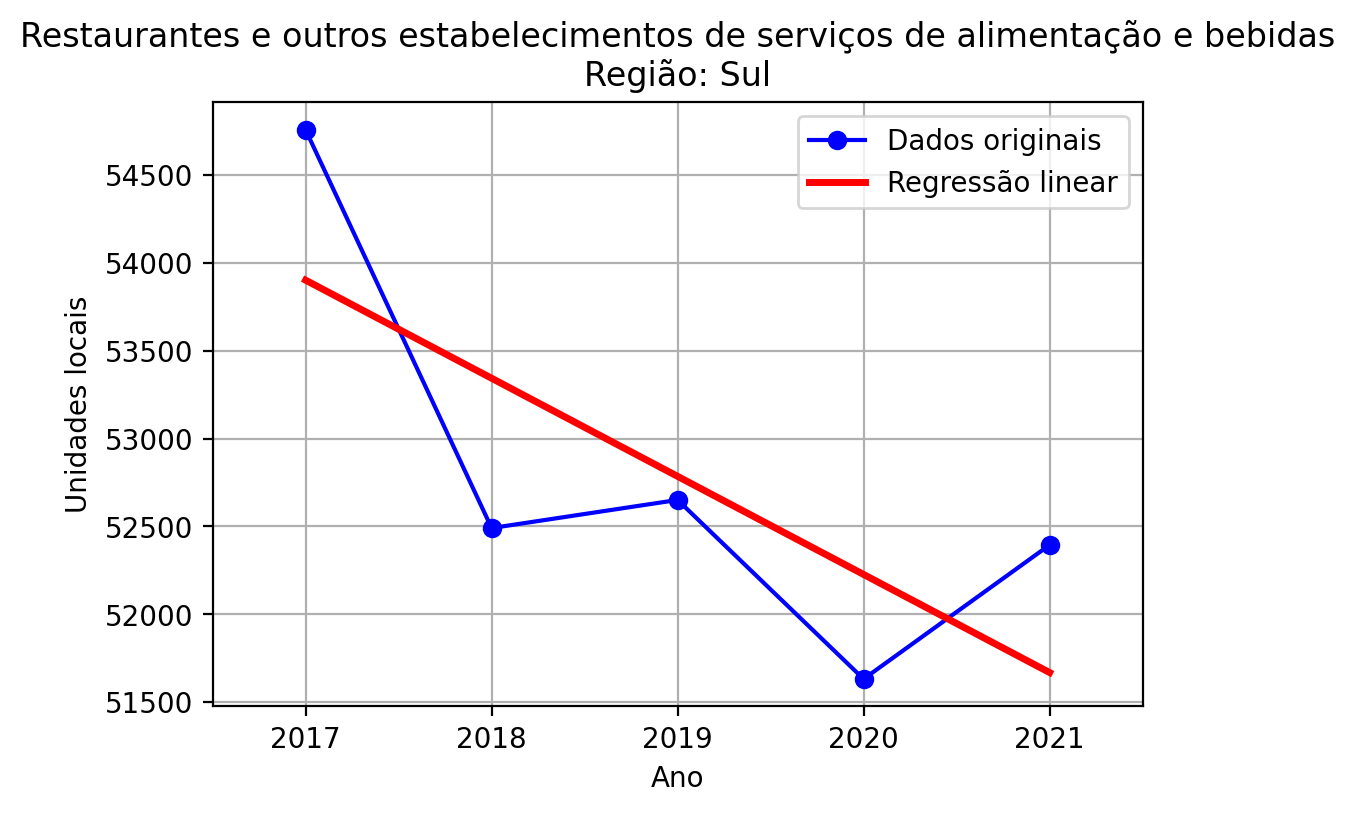

In [23]:
plot_lin_reg(df=grand_reg, ativ=atividades['rest'], reg=gd_rgs['SU'])

Esta célula foi rodada apenas uma vez para o gráfico com todas as quantidades.

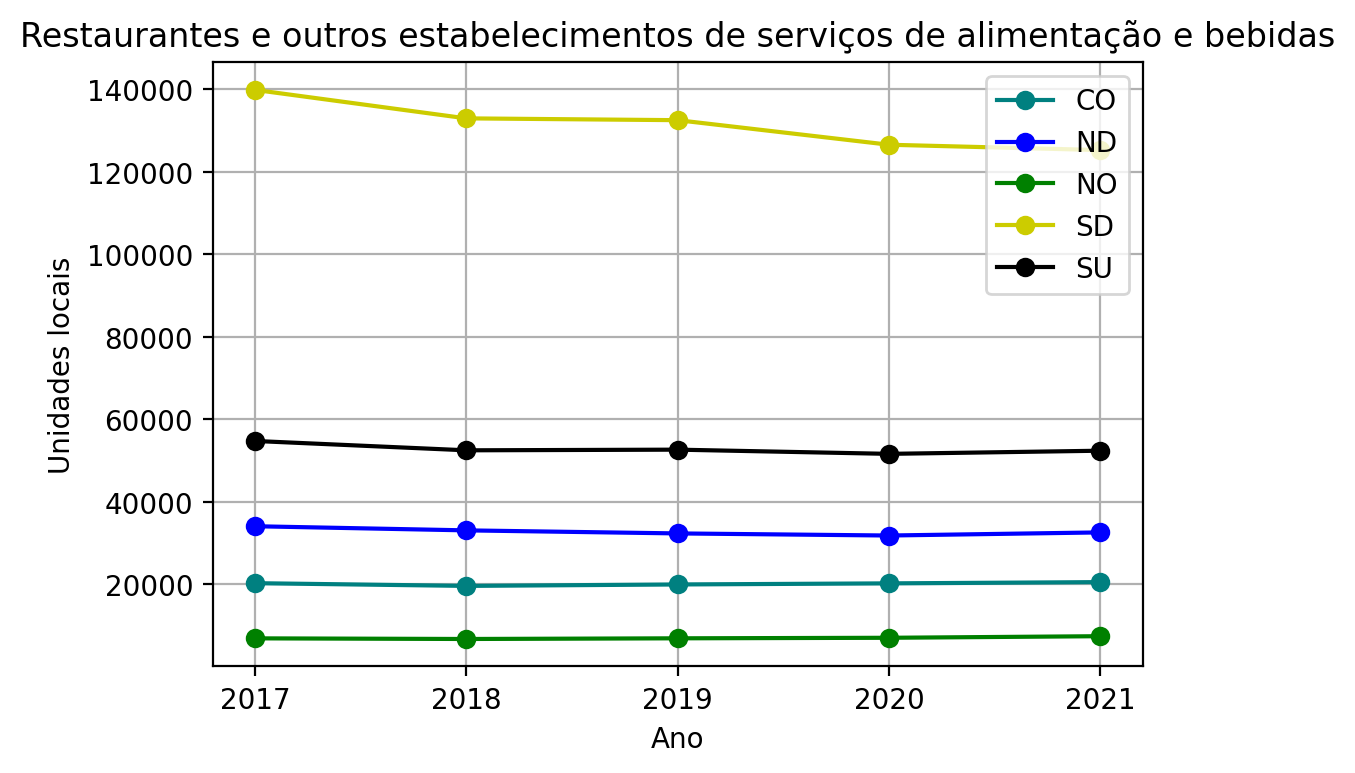

In [24]:
plot_all_in_one(df=grand_reg, ativ=atividades['rest'], regs=gd_rgs)

### $R^2$ e previsões

Aqui fazemos um laço para criação de um dicionário com os valores de $R^2$ necessários, bem como listas de previsões de 2022 e 2023.

In [25]:
lista_r2 = {}
previsoes_2022 = []
previsoes_2023 = []

for ind, key in enumerate(gd_rgs.keys()):
    lr_data = subconj_df(df=grand_reg, ativ=atividades['rest'], reg=gd_rgs[key])
    a, b, r2 = calculo_reg_lin(df=lr_data)
    lista_r2[key] = r2
    previsoes_2022.append(a*2022 + b)
    previsoes_2023.append(a*2023 + b)

Lista de valores de $R^2$:

In [26]:
lista_r2

{'CO': 0.26360459433843786,
 'ND': 0.6164360357775392,
 'NO': 0.6800795800237973,
 'SD': 0.9291156046933471,
 'SU': 0.5693458187766971}

Previsões de 2022:

In [27]:
np.floor(previsoes_2022)

array([[ 20457.],
       [ 31508.],
       [  7393.],
       [120795.],
       [ 51110.]])

Previsões de 2023:

In [28]:
np.floor(previsoes_2023)

array([[ 20571.],
       [ 31084.],
       [  7527.],
       [117236.],
       [ 50552.]])

## Correlações

### Funções auxiliares

Esta função cria a tabela pivô para determinação das correlações em cada região.

In [29]:
def df_pivot(df=None, reg=None, col1='Ano', col2='Atividade', col3='Unidades locais', col4='Região'):
    """Cria tabela pivô para uma dada região."""

    # Seleciona a região
    dados = df[df[col4] == reg]

    return dados.pivot(index=col1, columns=col2, values=col3)

Esta função cria a tabela de correlações com a correlação de todas as atividades com a atividade escolhida, no caso `Restaurantes`.

In [30]:
def corr_por_reg(df=None, grupo=gd_rgs, reg=None, lista_ativ=atividades, ativ='rest'):
    """Criação da tabela de correlação com a atividade, ordenada do maior para o menor."""

    # Cria todas as correlações com a tabela pivô
    todas_corr = df_pivot(df=df, reg=grupo[reg]).corr()

    # Cria a tabela de correlação ordenada
    corr_rest = todas_corr.loc[lista_ativ[ativ], :].sort_values(ascending=False).to_frame(name='Correlação')
    
    return corr_rest

### Funções auxiliares de gráficos

Esta função constrói o gráfico das maiores correlações com um dado corte para uma região.

In [31]:
def plot_maior_corr(corr=None, corte=None, col='Correlação', grupo=gd_rgs, reg=None, lista_ativ=atividades, ativ='rest'):
    """Função para construção do gráfico de maiores correlação, a partir de um valor de corte."""

    # Seleciona apenas valores acima do corte
    maiores = corr[corr[col] > corte]

    # Desenha o gráfico com valores exceto pela atividade em si
    maiores.iloc[1:, :].sort_values(by=col).plot.barh()

    # Informações adicionais do gráfico
    plt.title(f'Correlação com {lista_ativ[ativ]}' + f'\nRegião {grupo[reg]}', loc='center')
    plt.gcf().set_dpi(200)
    plt.show()

Esta função constrói o gráfico das menores correlações com um dado corte para uma região.

In [32]:
def plot_menor_corr(corr=None, corte=None, col='Correlação', grupo=gd_rgs, reg=None, lista_ativ=atividades, ativ='rest'):
    """Função para construção do gráfico de menores correlações, a partir de um valor de corte."""

    # Seleciona apenas valores abaixo do corte
    menores = corr[corr[col] < corte]

    # Desenha o gráfico com valores
    menores.sort_values(by=col, ascending=False).plot.barh(color='magenta')

    # Informações adicionais do gráfico
    plt.title(f'Correlação com {lista_ativ[ativ]}' + f'\nRegião {grupo[reg]}', loc='center')
    plt.gcf().set_dpi(200)
    plt.show()

Esta célula foi rodada várias vezes para construção do gráfico de maiores correlações de cada região. A imagem foi salva manualmente.

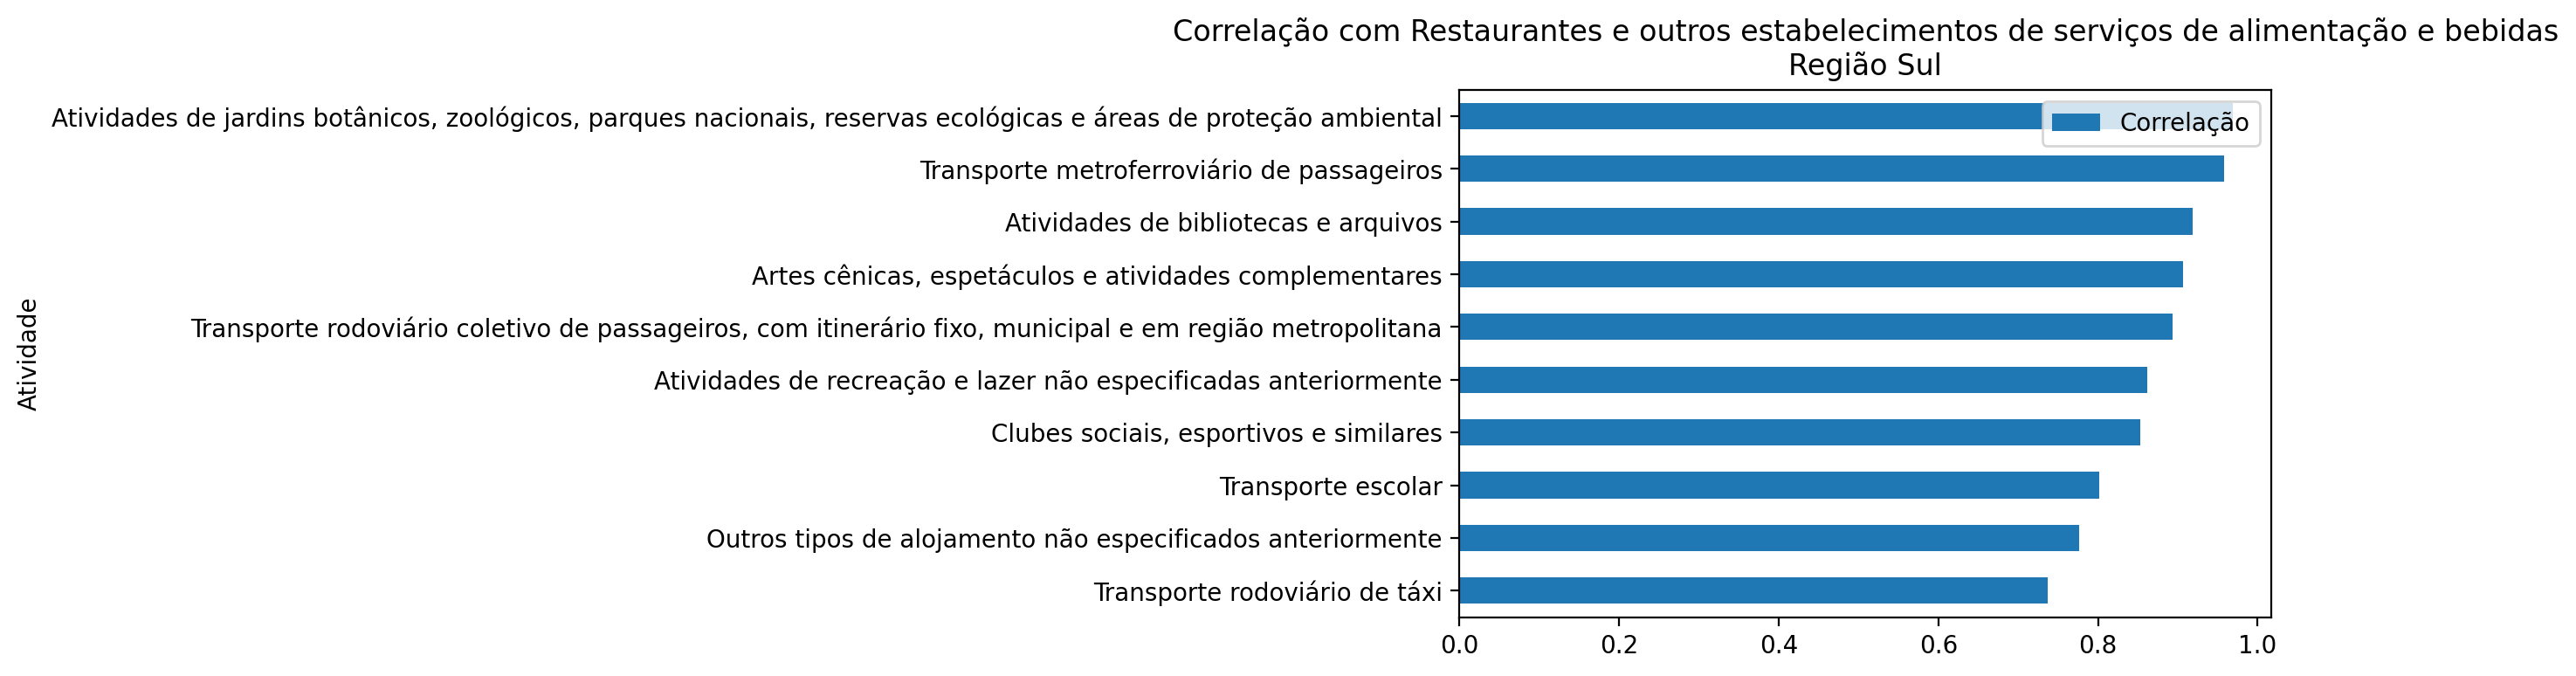

In [33]:
corr_total = corr_por_reg(df=grand_reg, reg='SU')
plot_maior_corr(corr=corr_total, corte=0.7, reg='SU')

Esta célula foi rodada várias vezes para construção do gráfico de menores correlações de cada região. A imagem foi salva manualmente.

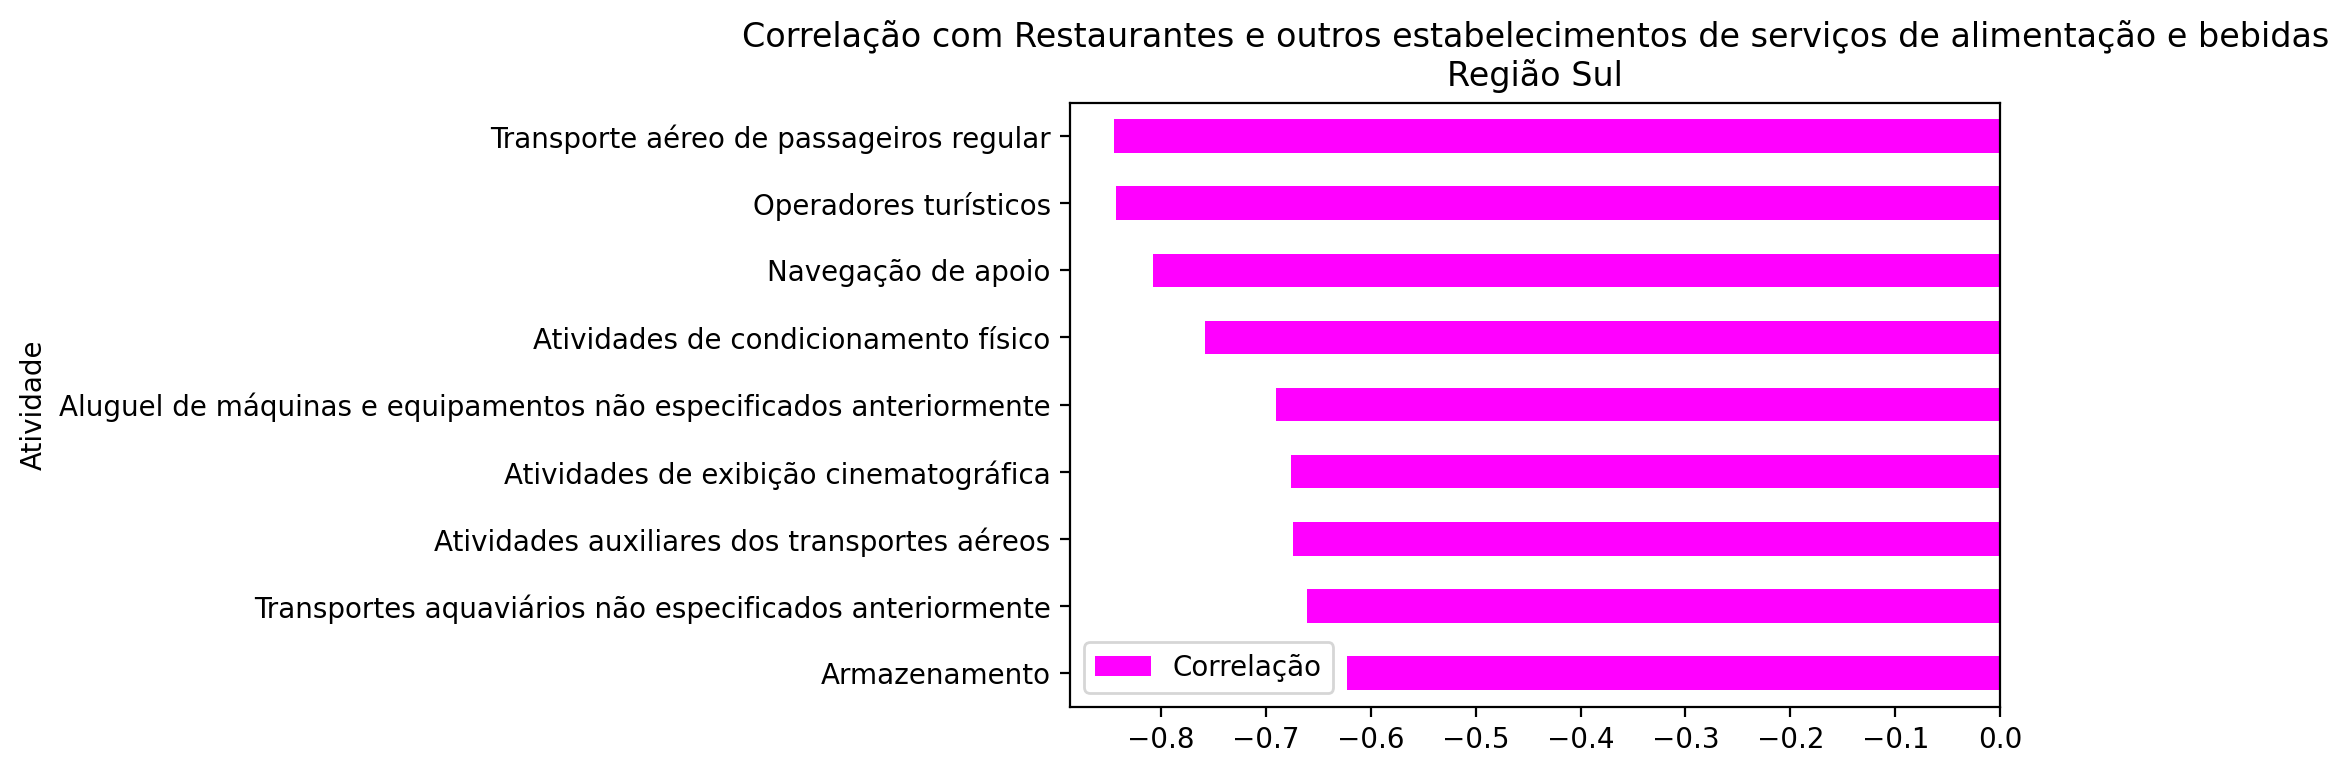

In [34]:
plot_menor_corr(corr=corr_total, corte=-0.6, reg='SU')

## Gradiente descendente

### Funções auxiliares

Esta função cria a tabela de dados com maior correlação com uma dada atividade a partir de um valor de corte.

In [35]:
def dados_maior_corr(df=None, reg=None, corte=None, grupo=gd_rgs, lista_ativ=atividades, ativ='rest', col='Correlação', col1='Atividade', col2='Região', col3='Ano', col4='Unidades locais'):
    """Cria a tabela de dados usada no gradiente descendente."""

    # Cria a correlação
    corr = corr_por_reg(df=df, reg=reg)

    # Seleciona as maiores
    maiores_corr = corr[corr[col] > corte]

    # Cria o conjunto das maiores atividades
    ativ_maior_corr = set(maiores_corr.index)

    # Cria os dados com essas atividades e seleciona por região
    gd_data = df[df[col1].isin(ativ_maior_corr)]
    gd_data = gd_data[gd_data[col2] == grupo[reg]]

    # Cria tabela pivô
    gd_data = gd_data.pivot(index=col3, columns=col1, values=col4)

    return gd_data

Essa função faz o cálculo do gradiente descendente, ajustando o modelo e calculando o $R^2$.

In [36]:
def calculo_grad_desc(df=None, max_iter=3000, lista_ativ=atividades, ativ='rest'):
    """Função que cria a pipeline para o gradiente descendente."""

    # Faz o scaling dos dados e depois aplica o gradiente descendente
    grad_desc = make_pipeline(StandardScaler(), SGDRegressor(max_iter=max_iter))

    # Cria as colunas de características
    X = df.drop(columns=lista_ativ[ativ])

    # Cria a série da variável predita
    y = df[lista_ativ[ativ]]

    # Ajuste do modelo aos dados
    grad_desc.fit(X, y)

    # Cálculo do valor de R2
    score = grad_desc.score(X, y)

    return grad_desc, score, X, y

Essa função calcula a previsão do modelo para os valores originais da tabela.

In [37]:
def calculo_valores_orig(X=None, modelo=None):
    """Função para calcular a previsão do modelo para valores originais."""

    # Cria os valores originais das colunas
    x_test = [list(X.iloc[i, :]) for i in range(5)]

    # Faz as previsões com base no modelo
    y_test = np.floor(modelo.predict(x_test))

    return x_test, y_test

Essa função retorna as previsões para o ano seguinte, utilizando a média $\mu$ e com o desvio padrão $\sigma$.

In [38]:
def calculo_prev(df=None, modelo=None, lista_ativ=atividades, ativ='rest'):
    """Função do cálculo das previsões da média e com desvio padrão."""

    # Cálculo do desvio padrão
    std = np.floor(np.array(df.drop(columns=lista_ativ[ativ]).std()))

    # Cálculo da média da tabela
    orig = np.floor(np.array(df.drop(columns=lista_ativ[ativ]).mean()))
    
    # Valores das características para previsão
    X_pred_1 = orig
    X_pred_2 = orig + std
    X_pred_3 = orig - std

    # Valores preditos
    y_pred_1 = np.floor(modelo.predict([X_pred_1]))
    y_pred_2 = np.floor(modelo.predict([X_pred_2]))
    y_pred_3 = np.floor(modelo.predict([X_pred_3]))

    # Impressão dos valores
    print(f'Média: {X_pred_1}')
    print(f'Previsão: {y_pred_1}')
    print(f'Média + desvio padrão: {X_pred_2}')
    print(f'Previsão: {y_pred_2}')
    print(f'Média - desvio padrão: {X_pred_3}')
    print(f'Previsão: {y_pred_3}')

    return X_pred_1, y_pred_1, X_pred_2, y_pred_2, X_pred_3, y_pred_3

### Função auxiliar de gráfico

Essa função desenha o gradiente descendente no mesmo gráfico que os dados originais, para verificar a tendência e a previsão do modelo.

In [39]:
def plot_grad_desc(df=None, reg=None, corte=None, lista_ativ=atividades, ativ='rest', grupo=gd_rgs, col1='Ano', col2='Unidades locais'):
    """Função para desenhar o gradiente descendente com os dados originais."""

    # Criação da tabela
    gd_data = dados_maior_corr(df=df, reg=reg, corte=corte)

    # Ajuste do modelo
    modelo, _, X, _ = calculo_grad_desc(df=gd_data, max_iter=10000)

    # Previsões para os valores originais
    _, y_test = calculo_valores_orig(X=X, modelo=modelo)

    # Tabela original por atividade e região
    orig = subconj_df(df=df, ativ=lista_ativ[ativ], reg=grupo[reg])

    # Valores da horizontal do gráfico
    anos = orig[col1].unique()
    
    # Desenho do gráfico e do gradiente descendente
    plt.plot(orig[col1], orig[col2], 'o-', color='blue', label='Dados originais')
    plt.plot(anos, y_test, 'o--', color='red', label='Gradiente descendente')

    # Informações adicionais do gráfico
    plt.legend()
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.xticks(orig[col1])
    plt.title('Comparação gradiente descendente com dados originais' + f'\nRegião {grupo[reg]}')

    plt.gcf().set_dpi(200)
    plt.grid(visible=True)
    plt.show()

Esta célula foi rodada várias vezes para a determinação dos valores de $R^2$ para o modelo de gradiente descendente.

In [40]:
gd_data = dados_maior_corr(df=grand_reg, reg='SD', corte=0.7)
modelo, score, X, y = calculo_grad_desc(df=gd_data, max_iter=10000)
score

0.9999999479425681

Esta célula foi rodada várias vezes para determinação dos valores preditos com média $\mu$ e desvio padrão $\sigma$.

In [41]:
gd_data = dados_maior_corr(df=grand_reg, reg='CO', corte=0.8)
modelo, score, X, y = calculo_grad_desc(df=gd_data, max_iter=30000)
calculo_prev(df=gd_data, modelo=modelo)

Média: [1.092e+03 5.300e+01 3.470e+02 1.030e+02 3.819e+03 3.000e+00]
Previsão: [20100.]
Média + desvio padrão: [1.140e+03 5.700e+01 3.830e+02 1.130e+02 4.048e+03 4.000e+00]
Previsão: [20494.]
Média - desvio padrão: [1.044e+03 4.900e+01 3.110e+02 9.300e+01 3.590e+03 2.000e+00]
Previsão: [19706.]


c:\Users\marce\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\marce\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\marce\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(array([1.092e+03, 5.300e+01, 3.470e+02, 1.030e+02, 3.819e+03, 3.000e+00]),
 array([20100.]),
 array([1.140e+03, 5.700e+01, 3.830e+02, 1.130e+02, 4.048e+03, 4.000e+00]),
 array([20494.]),
 array([1.044e+03, 4.900e+01, 3.110e+02, 9.300e+01, 3.590e+03, 2.000e+00]),
 array([19706.]))

Esta célula foi rodada várias vezes para cada região para construção do gráfico do gradiente descendente juntamente com os pontos originais.

c:\Users\marce\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\marce\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


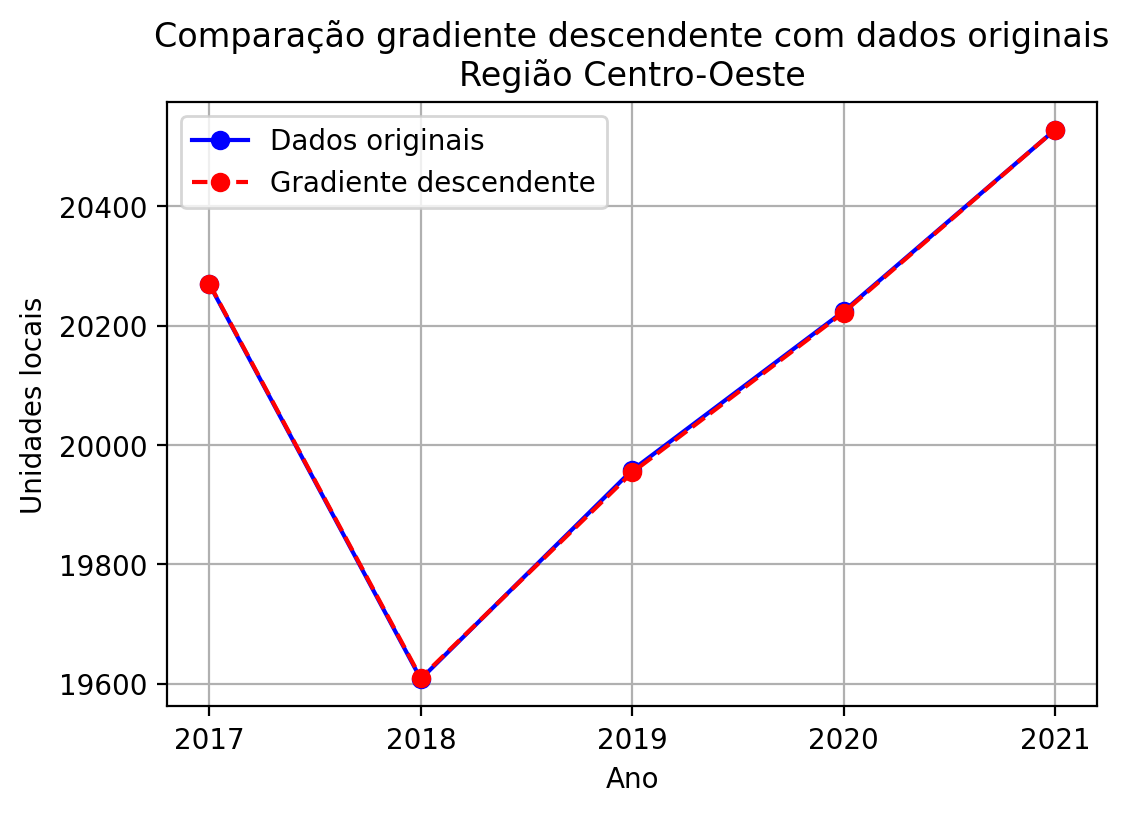

In [42]:
plot_grad_desc(df=grand_reg, reg='CO', corte=0.8)